In [204]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle, warnings
import shap

from fair_func import *
from fair_metrics import *
from ACF import ACF


from xgboost import XGBClassifier
from sklearn.metrics import mutual_info_score, recall_score, f1_score, roc_curve, auc, accuracy_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from joblib import Parallel, delayed
from diffprivlib import models as dp
from datetime import datetime


pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
warnings.filterwarnings("ignore")

scaler = StandardScaler()

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [205]:
df = pd.read_csv('data.csv', sep=";")
df.shape

(4424, 37)

## Target

We converted 3-class problem into 2-class problem by merging ```Enrolled``` and ```Graduate``` as one class.

The ```Target``` column gives whether the student will dropout or not where 1 means Dropout and 0 means not

In [206]:
df.Target.replace(['Enrolled', 'Graduate'], 0, inplace=True)
df.Target.replace('Dropout', 1, inplace=True)

## Nacionality

- 1 - Portuguese
- 2 - German
- 6 - Spanish
- 11 - Italian
- 13 - Dutch
- 14 - English
- 17 - Lithuanian
- 21 - Angolan
- 22 - Cape Verdean
- 24 - Guinean
- 25 - Mozambican
- 26 - Santomean
- 32 - Turkish
- 41 - Brazilian
- 62 - Romanian
- 100 - Moldova (Republic of)
- 101 - Mexican
- 103 - Ukrainian
- 105 - Russian
- 108 - Cuban
- 109 - Colombian	

### Combinations:
- 1 as "Portuguese"
- remaining as "Others"

In [207]:
df.Nacionality.replace(1, 0, inplace=True)
df.Nacionality.replace(list(range(2, 110)), 1, inplace=True)

df.Nacionality.value_counts()

0    4314
1     110
Name: Nacionality, dtype: int64

In [208]:
df[['International', 'Nacionality']].corr()

,International,Nacionality
International,1.0,1.0
Nacionality,1.0,1.0


Since there is direct relation between ```International``` and ```Nacionality```, we are dropping ```Internatinoal``` column from our dataset

In [209]:
df.drop('International', axis=1, inplace=True)

We have an unsaid rule that the qualification is directly related to the occupation of the person. Therefore, we are removing the ```Father's Qualification``` and ```Mother's Occupation``` from our dataset.

In [210]:
df.drop(['Father_qualification', 'Mother_occupation'], axis=1, inplace=True)

## Marital Status:
- 1 – single 2 – married 3 – widower 4 – divorced 5 – facto union 6 – legally separated
- Since the column had 5 status, we converted them into 2 status ```Married``` and ```Un-Married```
- Our binning is done in the following manner:
    - Married and Facto Union as ```Married``` and is labelled as ```1```
    - Remaining as ```Un-Married``` and is labelled as ```0```

In [211]:
df.Marital_status.replace([1, 3, 4, 6], 0, inplace=True)
df.Marital_status.replace([2, 5], 1, inplace=True)

df.Marital_status.value_counts()

0    4020
1     404
Name: Marital_status, dtype: int64

## Application Mode:
- 1 - 1st phase - general contingent 
- 2 - Ordinance No. 612/93 
- 5 - 1st phase - special contingent (Azores Island) 
- 7 - Holders of other higher courses 
- 10 - Ordinance No. 854-B/99 
- 15 - International student (bachelor) 
- 16 - 1st phase - special contingent (Madeira Island) 
- 17 - 2nd phase - general contingent 
- 18 - 3rd phase - general contingent 
- 26 - Ordinance No. 533-A/99, item b2) (Different Plan) 
- 27 - Ordinance No. 533-A/99, item b3 (Other Institution) 
- 39 - Over 23 years old 
- 42 - Transfer 
- 43 - Change of course 
- 44 - Technological specialization diploma holders 
- 51 - Change of institution/course 
- 53 - Short cycle diploma holders 
- 57 - Change of institution/course (International)

From above entries:
- 2, 26, 27, 10 can be clubbed into one "Others"
- 1, 5, 16 cab be combined into "First_Phase"
- 43, 51, 57 can be clubbed into "Course_Change"
- 7, 44, 53 can be clubbed into "Courses_Holders"
- 17, 18 can be clubbed into "Last_Phase"
- 15, 42 can be clubbed into "Transfer"
- 39 => "OverAge"

In [212]:
df.Application_mode.replace([2, 26, 27, 10], 'Others', inplace=True)
df.Application_mode.replace([1, 5, 16], "First_Phase", inplace=True)
df.Application_mode.replace([43, 51, 57], "Course_Change", inplace=True)
df.Application_mode.replace([7, 44, 53], "Courses_Holders", inplace=True)
df.Application_mode.replace([17, 18], "Last_Phase", inplace=True)
df.Application_mode.replace([15, 42], "Transfer", inplace=True)
df.Application_mode.replace(39, "OverAge", inplace=True)

## Application Order
- Application order (between 0 - first choice; and 9 last choice)
- Combinations:
    - 0, 1 as "First_Choice"
    - 2 as "Second_Choice"
    - 3, 4 as "Second_Last_Choice"
    - 5, 6, 9 as "Last_Choice"

In [213]:
df.Application_order.value_counts()

1    3026
2     547
3     309
4     249
5     154
6     137
9       1
0       1
Name: Application_order, dtype: int64

## Course
- 33 - Biofuel Production Technologies 
- 171 - Animation and Multimedia Design 
- 8014 - Social Service (evening attendance) 
- 9003 - Agronomy 
- 9070 - Communication Design 
- 9085 - Veterinary Nursing 
- 9119 - Informatics Engineering 
- 9130 - Equinculture 
- 9147 - Management 
- 9238 - Social Service 
- 9254 - Tourism 
- 9500 - Nursing 
- 9556 - Oral Hygiene 
- 9670 - Advertising and Marketing Management 
- 9773 - Journalism and Communication 
- 9853 - Basic Education 
- 9991 - Management (evening attendance)

Combinations: 
- 9085, 9500, 9556 as "Medical"
- 9147, 9670, 9991 as "Management"
- 33, 171, 9119 as "Technology"
- 9003, 9130 as "Nature"
- 9238, 8014 as "Social_Service"
- 9070, 9773 as "Communication"
- 9254, 9853 as "Others"

We have combined the values into the above 7 courses and will be applicabe for One-Hot Encoding.

In [214]:
df.Course.replace([9085, 9500, 9556], "Medical", inplace=True)
df.Course.replace([9147, 9670, 9991], "Management", inplace=True)
df.Course.replace([33, 171, 9119], "Technology", inplace=True)
df.Course.replace([9003, 9130], "Nature", inplace=True)
df.Course.replace([9238, 8014], "Social_Service", inplace=True)
df.Course.replace([9070, 9773], "Communication", inplace=True)
df.Course.replace([9254, 9853], "Others", inplace=True)

pd.crosstab(df.Target, df.Course)

Course,Communication,Management,Medical,Nature,Others,Social_Service,Technology
Target,,,,,,,
0,405,551,948,187,263,434,215
1,152,365,241,164,181,136,182


## Previous Qualification

- 1 - Secondary education 
- 2 - Higher education - bachelor's degree 
- 3 - Higher education - degree 
- 4 - Higher education - master's 
- 5 - Higher education - doctorate 
- 6 - Frequency of higher education 
- 9 - 12th year of schooling - not completed 
- 10 - 11th year of schooling - not completed 
- 12 - Other - 11th year of schooling 
- 14 - 10th year of schooling 
- 15 - 10th year of schooling - not completed 
- 19 - Basic education 3rd cycle (9th/10th/11th year) or equiv. 
- 38 - Basic education 2nd cycle (6th/7th/8th year) or equiv. 
- 39 - Technological specialization course 
- 40 - Higher education - degree (1st cycle) 
- 42 - Professional higher technical course 
- 43 - Higher education - master (2nd cycle)

We have combined the values into 4 generic labels 

In [215]:
df.Previous_qualification.replace([35, 34], 'Others', inplace=True)
df.Previous_qualification.replace([2, 3, 4, 5, 6, 18, 22, 39, 40, 41, 42, 43, 44], 'Graduation_plus', inplace=True)
df.Previous_qualification.replace([1, 9, 10, 12, 19, 27], 'High_School_Eq', inplace=True)
df.Previous_qualification.replace([11, 14, 15, 26, 29, 30, 36, 37, 38], 'Basic_Education', inplace=True)

pd.crosstab(df.Target, df.Previous_qualification)

Previous_qualification,Basic_Education,Graduation_plus,High_School_Eq
Target,,,
0,5,281,2717
1,5,194,1222


## Mother's Qualification

- 1 - Secondary Education - 12th Year of Schooling or Eq. 
- 2 - Higher Education - Bachelor's Degree 
- 3 - Higher Education - Degree 
- 4 - Higher Education - Master's 
- 5 - Higher Education - Doctorate 
- 6 - Frequency of Higher Education 
- 9 - 12th Year of Schooling - Not Completed 
- 10 - 11th Year of Schooling - Not Completed 
- 11 - 7th Year (Old) 
- 12 - Other - 11th Year of Schooling 
- 14 - 10th Year of Schooling 
- 18 - General commerce course 
- 19 - Basic Education 3rd Cycle (9th/10th/11th Year) or Equiv. 
- 22 - Technical-professional course 
- 26 - 7th year of schooling 
- 27 - 2nd cycle of the general high school course 
- 29 - 9th Year of Schooling - Not Completed 
- 30 - 8th year of schooling 
- 34 - Unknown 
- 35 - Can't read or write 
- 36 - Can read without having a 4th year of schooling 
- 37 - Basic education 1st cycle (4th/5th year) or equiv. 
- 38 - Basic Education 2nd Cycle (6th/7th/8th Year) or Equiv. 
- 39 - Technological specialization course 
- 40 - Higher education - degree (1st cycle) 
- 41 - Specialized higher studies course 
- 42 - Professional higher technical course 
- 43 - Higher Education - Master (2nd cycle) 
- 44 - Higher Education - Doctorate (3rd cycle)

In [216]:
df.Mother_qualification.replace([35, 34], 'Others', inplace=True)
df.Mother_qualification.replace([2, 3, 4, 5, 6, 18, 22, 39, 40, 41, 42, 43, 44], 'Graduation_plus', inplace=True)
df.Mother_qualification.replace([1, 9, 10, 12, 19, 27], 'High_School_Eq', inplace=True)
df.Mother_qualification.replace([11, 14, 26, 29, 30, 36, 37, 38], 'Basic_Education', inplace=True)

pd.crosstab(df.Target, df.Mother_qualification)

Mother_qualification,Basic_Education,Graduation_plus,High_School_Eq,Others
Target,,,,
0,1056,437,1475,35
1,530,192,601,98


## Father's Occupation

In [217]:
df.Father_occupation.replace([0, 90, 99], "Others", inplace=True)
df.Father_occupation.replace([9, 151, 152, 153, 163, 175, 192, 193, 194, 195], "Unskilled", inplace=True)
df.Father_occupation.replace([3, 4, 5, 6, 7, 8, 131, 132, 134, 135, 141, 143, 144, 154, 161, 171, 172, 174, 181, 182, 183], "Skilled", inplace=True)
df.Father_occupation.replace([1, 2, 10, 101, 102, 103, 112, 114, 121, 122, 123, 124], "Highly_Skilled", inplace=True)

pd.crosstab(df.Target, df.Father_occupation)

Father_occupation,Highly_Skilled,Others,Skilled,Unskilled
Target,,,,
0,409,71,1801,722
1,205,141,748,327


In [218]:
categorical_columns = ['Father_occupation', 'Mother_qualification', 'Previous_qualification', 'Course', 'Application_mode']
categorical_columns

['Father_occupation',
 'Mother_qualification',
 'Previous_qualification',
 'Course',
 'Application_mode']

In [219]:
dummied_df = pd.get_dummies(df, columns=categorical_columns)

In [220]:
dummied_df.shape

(4424, 54)

# Calculate VIF for continouous features

In [221]:
def calculate_vif_(X, thresh=5.0):
    variables = [X.columns[i] for i in range(X.shape[1])]
    dropped=True
    while dropped:
        dropped=False
        
        vif = Parallel(n_jobs=-1,verbose=5)(delayed(variance_inflation_factor)(X[variables].values, ix) 
                                            for ix in range(len(variables)))
 
        maxloc = vif.index(max(vif))
        if max(vif) > thresh:
            print ('VIF is ' + str(max(vif)) + ' ' + 'dropping ' + X[variables].columns[maxloc])
            
            variables.pop(maxloc)
            dropped=True
 
    return variables

In [222]:
df_numerical = df[['enrollment_age', 'Curricular_units_1st_sem_credited', 'Curricular_units_1st_sem_enrolled',
       'Curricular_units_1st_sem_evaluations',
       'Curricular_units_1st_sem_approved', 'Curricular_units_1st_sem_grade',
       'Curricular_units_1st_sem_without_evaluations',
       'Curricular_units_2nd_sem_credited',
       'Curricular_units_2nd_sem_enrolled',
       'Curricular_units_2nd_sem_evaluations',
       'Curricular_units_2nd_sem_approved', 'Curricular_units_2nd_sem_grade',
       'Curricular_units_2nd_sem_without_evaluations', 'Unemployment_rate',
       'Inflation_rate', 'GDP']]

rem_cols = calculate_vif_(df_numerical)

col_to_remove = df_numerical.columns[~df_numerical.columns.isin(rem_cols)]
updated_df = dummied_df.drop(columns=col_to_remove)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of  16 | elapsed:    3.0s remaining:    6.6s
[Parallel(n_jobs=-1)]: Done   9 out of  16 | elapsed:    3.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  13 out of  16 | elapsed:    3.0s remaining:    0.6s


KeyboardInterrupt: 

In [ ]:
dropped_df = updated_df.drop('Marital_status', axis=1)
proxy_features = []
for i in dropped_df.columns:
    mi = mutual_info_score(updated_df.Marital_status, dropped_df[i])
    if mi > 0.1:
        proxy_features.append(i)
print(proxy_features)

['enrollment_age']


## Extract features from dataset infortant to the Target

In [ ]:
X = updated_df.drop('Target', axis=1)
Y = updated_df.Target


model = XGBClassifier()
model.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

In [ ]:
imp_df = pd.DataFrame({'Colname': X.columns, 'importance': model.feature_importances_})
imp_df.sort_values(by='importance', ascending=False, inplace=True)

In [ ]:
imp_df.shape

(44, 2)

In [ ]:
cols_to_remove = imp_df[imp_df.importance == 0.0].Colname.values

In [ ]:
cols_to_remove

array(['Previous_qualification_High_School_Eq',
       'Previous_qualification_Basic_Education',
       'Application_mode_Others'], dtype=object)

## Create final CSV for easy usage

In [ ]:
final_df = updated_df[imp_df.Colname[~imp_df.Colname.isin(cols_to_remove)].values]
final_df['Target'] = updated_df.Target

final_df.to_csv("dataset_featured_v2.csv", index=False)

In [ ]:
final_df.shape

(4424, 42)

# Apply noise on enrollment_age

In [ ]:
df = final_df.copy()
df_raw = final_df.copy()

In [ ]:
sensitivity = df.enrollment_age.max()/(df.shape[0]+1)
sensitivity

0.015819209039548022

In [ ]:
original = df.enrollment_age.mean()

V=[]
ep=[]
count=[]

for j in range (1,6):
    epsilon = j/10
    for k in range(0,df.enrollment_age.shape[0]):
        value = df.enrollment_age.loc[k] + np.random.laplace(loc=0, scale=sensitivity/epsilon)
        V.append(value)
        ep.append(epsilon)
        count.append(k)

In [ ]:
fra = pd.DataFrame({'Value':V, 'ep':ep, 'count':count})
print(original)

epsilon_difference = []

for eps, grouped_data in fra.groupby('ep'):
    grouped_mean = grouped_data['Value'].mean()
    epsilon_difference.append((eps, grouped_mean - original))
    print(eps, f"Epsilon_mean: {grouped_mean}\t Mean_Difference:{grouped_mean - original}")

23.265144665461122
0.1 Epsilon_mean: 23.27230490936672	 Mean_Difference:0.007160243905598662
0.2 Epsilon_mean: 23.260999825851034	 Mean_Difference:-0.004144839610088269
0.3 Epsilon_mean: 23.265137867271424	 Mean_Difference:-6.79818969828716e-06
0.4 Epsilon_mean: 23.262900007296306	 Mean_Difference:-0.0022446581648161157
0.5 Epsilon_mean: 23.265973688595256	 Mean_Difference:0.0008290231341341325


In [ ]:
nearest_epsilon = min(epsilon_difference, key=lambda x: abs(x[1]-0))
epsilon_to_consider = nearest_epsilon[0]
print(epsilon_to_consider)

0.3


In [ ]:
for k in range(0,df.enrollment_age.shape[0]):
    df.enrollment_age.loc[k] = df.enrollment_age.loc[k] + np.random.laplace(loc=0, scale=sensitivity/epsilon_to_consider)

# Models without Re-Weighting

In [ ]:
columns_to_drop = ['Marital_status', 'Gender', 'Nacionality', 'Target'] # Removed PII features and Target for modelling

In [ ]:
X_dp = df.drop(columns=columns_to_drop, axis=1)
Y_dp = df.Target
X_raw = df_raw.drop(columns=columns_to_drop, axis=1)
Y_raw = df_raw.Target

X_train_dp, X_test_dp, y_train_dp, y_test_dp = train_test_split(X_dp, Y_dp, test_size=0.30, random_state=42)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, Y_raw, test_size=0.30, random_state=42)

X_train_dp_scaled = scaler.fit_transform(X_train_dp)
X_test_dp_scaled = scaler.fit_transform(X_test_dp)

X_train_raw_scaled = scaler.fit_transform(X_train_raw)
X_test_raw_scaled = scaler.fit_transform(X_test_raw)

In [ ]:
models_to_run = {
    'Raw_Data': {
        'DiffPrivLib': {
            'RandomForest': {
                'X_train': X_train_raw,
                'X_test': X_test_raw,
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_diff_rf.pkl",
                'MinMax': (X_train_raw.min().min(), X_train_raw.max().max())
            },
            'LogisticRegression': {
                'X_train': X_train_raw_scaled,
                'X_test': X_test_raw_scaled,
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_diff_lr.pkl",
                'MinMax': (X_train_raw_scaled.min().min(), X_train_raw_scaled.max().max())
            } 
        },
        'SKLearn': {
            'RandomForest': {
                'X_train': X_train_raw,
                'X_test': X_test_raw,
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_sklearn_rf.pkl",
                'MinMax': (X_train_raw.min().min(), X_train_raw.max().max())
            },
            'LogisticRegression': {
                'X_train': X_train_raw_scaled,
                'X_test': X_test_raw_scaled,
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_sklearn_lr.pkl",
                'MinMax': (X_train_raw_scaled.min().min(), X_train_raw_scaled.max().max())
            } 
        } 
    },
    'DP_Data': {
        'DiffPrivLib': {
            'RandomForest': {
                'X_train': X_train_dp,
                'X_test': X_test_dp,
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_diff_rf.pkl",
                'MinMax': (X_train_dp.min().min(), X_train_dp.max().max())
            },
            'LogisticRegression': {
                'X_train': X_train_dp_scaled,
                'X_test': X_test_dp_scaled,
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_diff_lr.pkl",
                'MinMax': (X_train_dp_scaled.min().min(), X_train_dp_scaled.max().max())
            } 
        },
        'SKLearn': {
            'RandomForest': {
                'X_train': X_train_dp,
                'X_test': X_test_dp,
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_sklearn_rf.pkl",
                'MinMax': (X_train_dp.min().min(), X_train_dp.max().max())
            },
            'LogisticRegression': {
                'X_train': X_train_dp_scaled,
                'X_test': X_test_dp_scaled,
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_sklearn_lr.pkl",
                'MinMax': (X_train_dp_scaled.min().min(), X_train_dp_scaled.max().max())
            } 
        } 
    }
}

In [ ]:
forest_depth = 10

def get_predictions(model, inputs):
    model.fit(inputs['X_train'], inputs['Y_train'])
    y_pred = model.predict(inputs['X_test'])
    return y_pred

def get_FNR(y_test, y_pred):
    tpr = recall_score(y_test, y_pred)
    tnr = recall_score(y_test, y_pred, pos_label=0)

    fpr = 1 - tnr
    fnr = 1 - tpr

    return fnr

def get_metrics(y_test, y_pred):
    fnr_val = get_FNR(y_test, y_pred)
    f1_val = f1_score(y_test, y_pred)
    fpr, tpr, threshold = roc_curve(y_test, y_pred)
    auc_val = auc(fpr, tpr)
    acc_val = accuracy_score(y_test, y_pred)
    return fnr_val, f1_val, auc_val, acc_val

def get_metrics_for_model(model, inputs):
    y_pred = get_predictions(model, inputs)
    metrics = get_metrics(inputs['Y_test'], y_pred)
    return metrics

def get_best_metrics(metrices):
    fnrs = []
    f1s = []
    eps = []

    for metric in metrices:
        fnrs.append(metric[0][0])
        f1s.append(metric[0][1])
        eps.append(metric[1])

    m_df = pd.DataFrame({'FNR': fnrs, 'F1': f1s, 'Eps': eps})
    output = m_df.sort_values(by = ['FNR', 'F1'], ascending = [True, False])
    return output.iloc[0]

def get_max_l2_norm(inputs):
    train = inputs['X_train']
    norms = np.sqrt(np.square(X_test_raw).sum(axis=1))
    return norms.values.max()

def get_dp_model(modelType, epsilon, inputs):
    model = None
    if modelType == "RandomForest":
        minmax = inputs['MinMax']
        model = dp.RandomForestClassifier(epsilon=epsilon, n_estimators=100, random_state=42, classes=inputs['Y_train'].unique(), n_jobs=-1, max_depth=forest_depth)
    else:
        data_norm = get_max_l2_norm(inputs)
        model = dp.LogisticRegression(epsilon=epsilon, random_state=42, data_norm=data_norm, n_jobs=-1)
    return model

def get_sklearn_model(modelType):
    model = None
    if modelType == "RandomForest":
        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1, max_depth=forest_depth)
    else:
        model = LogisticRegression(random_state=42, n_jobs=-1)
    return model

def get_best_epsilon(modelType, inputs):
    epsilons_to_consider = [round(x, 1) for x in list(np.arange(0.1, 1.1, 0.1))]
    metrices = []

    for epsilon in epsilons_to_consider:
        starttime = datetime.now()
        model = get_dp_model(modelType, epsilon, inputs)
        metrics = get_metrics_for_model(model, inputs)
        endtime = datetime.now()
        diff = endtime - starttime
        print(f"Model: {modelType}, Epsilon: {epsilon}, Time Taken: {diff}")
        metrices.append((metrics, epsilon))
    
    best_metrics = get_best_metrics(metrices)
    return best_metrics['Eps']

def get_model(package_name, model_name, inputs):
    if package_name == "DiffPrivLib":
        epsilon = get_best_epsilon(model_name, inputs)
        model = get_dp_model(model_name, epsilon, inputs)
        return model

    return get_sklearn_model(model_name)

def get_model_with_metrics(package_name, model_name, inputs):
    model = get_model(package_name, model_name, inputs)
    return get_metrics_for_model(model, inputs), model

In [ ]:
datatype = []
package = []
model = []
accuracy = []
mae = []
mse = []
rmse = []

f1 = []
fnr = []
aucs = []

for data, models in models_to_run.items():
    for package_name, model_inputs in models.items():
        for model_name, inputs in model_inputs.items():          
            datatype.append(data)
            package.append(package_name)
            model.append(model_name)

            metrics, mdl = get_model_with_metrics(package_name, model_name, inputs)
            f1.append(metrics[1])
            fnr.append(metrics[0])
            aucs.append(metrics[2])
            accuracy.append(metrics[3])

            with open(f"picklefiles/without_reweight/{inputs['PickleFileName']}", 'wb') as input_file:
                pickle.dump(mdl, input_file)

Model: RandomForest, Epsilon: 0.1, Time Taken: 0:00:09.546696
Model: RandomForest, Epsilon: 0.2, Time Taken: 0:00:10.906312
Model: RandomForest, Epsilon: 0.3, Time Taken: 0:00:09.858698
Model: RandomForest, Epsilon: 0.4, Time Taken: 0:00:09.832412
Model: RandomForest, Epsilon: 0.5, Time Taken: 0:00:10.174199
Model: RandomForest, Epsilon: 0.6, Time Taken: 0:00:10.014253
Model: RandomForest, Epsilon: 0.7, Time Taken: 0:00:09.710099
Model: RandomForest, Epsilon: 0.8, Time Taken: 0:00:09.804877
Model: RandomForest, Epsilon: 0.9, Time Taken: 0:00:10.855381
Model: RandomForest, Epsilon: 1.0, Time Taken: 0:00:11.825139
Model: LogisticRegression, Epsilon: 0.1, Time Taken: 0:00:00.128356
Model: LogisticRegression, Epsilon: 0.2, Time Taken: 0:00:00.130630
Model: LogisticRegression, Epsilon: 0.3, Time Taken: 0:00:00.143361
Model: LogisticRegression, Epsilon: 0.4, Time Taken: 0:00:00.137494
Model: LogisticRegression, Epsilon: 0.5, Time Taken: 0:00:00.136751
Model: LogisticRegression, Epsilon: 0.6,

In [ ]:
df_model_outputs_1 = pd.DataFrame({'DataType': datatype, 'Package': package, 'ModelName': model, 'F1': f1, 'FNR': fnr, 'AUC': aucs, 'Accuracy': accuracy})
df_model_outputs_1

,DataType,Package,ModelName,F1,FNR,AUC,Accuracy
0,Raw_Data,DiffPrivLib,RandomForest,0.250000,0.834467,0.543308,0.670181
1,Raw_Data,DiffPrivLib,LogisticRegression,0.541446,0.303855,0.630485,0.608434
2,Raw_Data,SKLearn,RandomForest,0.780669,0.285714,0.828394,0.866717
3,Raw_Data,SKLearn,LogisticRegression,0.793727,0.253968,0.839758,0.871235
4,DP_Data,DiffPrivLib,RandomForest,0.250429,0.834467,0.543871,0.670934
5,DP_Data,DiffPrivLib,LogisticRegression,0.541446,0.303855,0.630485,0.608434
6,DP_Data,SKLearn,RandomForest,0.786683,0.276644,0.832929,0.869729
7,DP_Data,SKLearn,LogisticRegression,0.793727,0.253968,0.839758,0.871235


# Reweighting Marital_status column

<AxesSubplot:xlabel='Target', ylabel='Marital_status'>

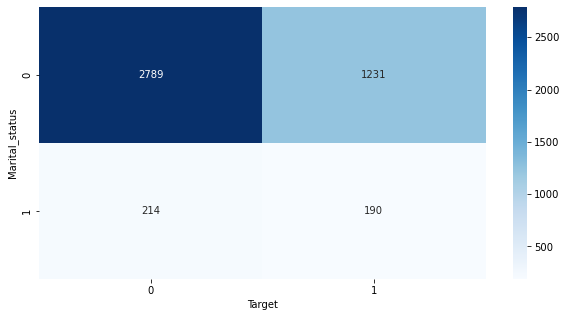

In [ ]:
plt.figure(figsize=(10, 5))
display(sns.heatmap(pd.crosstab(df_raw['Marital_status'],df_raw['Target']),annot=True , fmt="g", cmap='Blues'))

#0 - Unmarried    1 - Married
#0 - Graduate  1 - Dropout

In [ ]:
col = 'Marital_status'
s_adv = sum(df_raw[col] == 0)
s_disadv = sum(df_raw[col] == 1)
n = len(df_raw)
print("Advataged class count = ", s_adv)
print("Disadvantaged class count = ", s_disadv)

y_fav = sum(df_raw['Target'] == 0)
y_unfav = sum(df_raw['Target'] == 1)
print("Favourable class count = ",y_fav)
print("Unfavourable class count = ", y_unfav)

s_adv_y_fav = sum((df_raw[col] == 0) & (df_raw['Target'] == 0))
s_adv_y_unfav = sum((df_raw[col] == 0) & (df_raw['Target'] == 1))

s_disadv_y_fav = sum((df_raw[col] == 1) & (df_raw['Target'] == 0))
s_disadv_y_unfav = sum((df_raw[col] == 1) & (df_raw['Target'] == 1))

print('Count of advantaged class with favourable outcome', s_adv_y_fav)
print('Count of advantaged class with unfavourable outcome', s_adv_y_unfav)
print('Count of disadvantaged class with favourable outcome', s_disadv_y_fav)
print('Count of disadvantaged class with unfavourable outcome', s_disadv_y_unfav)

w_s_adv_y_fav = (s_adv*y_fav)/(s_adv_y_fav*n)
w_s_adv_y_unfav = (s_adv*y_unfav)/(s_adv_y_unfav*n)
w_s_disadv_y_fav = (s_disadv*y_fav)/(s_disadv_y_fav*n)
w_s_disadv_y_unfav = (s_disadv*y_unfav)/(s_disadv_y_unfav*n)

print('Weight of advantaged class with favourable outcome', w_s_adv_y_fav)
print('Weight of advantaged class with unfavourable outcome', w_s_adv_y_unfav)
print('Weight of disadvantaged class with favourable outcome', w_s_disadv_y_fav)
print('Weight of disadvantaged class with unfavourable outcome', w_s_disadv_y_unfav)

spd_before_reweighting = (s_adv_y_fav/s_adv) - (s_disadv_y_fav/s_disadv)
print("SPD before reweighting = ", spd_before_reweighting)
spd_after_reweighting = (s_adv_y_fav/s_adv)*w_s_adv_y_fav - (s_disadv_y_fav/s_disadv)*w_s_disadv_y_fav
print("SPD after reweighting = ", abs(spd_after_reweighting))

Advataged class count =  4020
Disadvantaged class count =  404
Favourable class count =  3003
Unfavourable class count =  1421
Count of advantaged class with favourable outcome 2789
Count of advantaged class with unfavourable outcome 1231
Count of disadvantaged class with favourable outcome 214
Count of disadvantaged class with unfavourable outcome 190
Weight of advantaged class with favourable outcome 0.9784029482914343
Weight of advantaged class with unfavourable outcome 1.0489310944071404
Weight of disadvantaged class with favourable outcome 1.28146811782799
Weight of disadvantaged class with unfavourable outcome 0.6829780146568954
SPD before reweighting =  0.1640781242303334
SPD after reweighting =  1.1102230246251565e-16


In [ ]:
df_raw['Marital_status_weight'] = 0
df_raw['Marital_status_weight'] = np.where((df_raw['Marital_status'] == 0 ) & (df_raw['Target'] == 0), w_s_adv_y_fav, df_raw['Marital_status_weight'])
df_raw['Marital_status_weight'] = np.where((df_raw['Marital_status'] == 0 ) & (df_raw['Target'] == 1), w_s_adv_y_unfav, df_raw['Marital_status_weight'])
df_raw['Marital_status_weight'] = np.where((df_raw['Marital_status'] == 1 ) & (df_raw['Target'] == 0), w_s_disadv_y_fav, df_raw['Marital_status_weight'])
df_raw['Marital_status_weight'] = np.where((df_raw['Marital_status'] == 1 ) & (df_raw['Target'] == 1), w_s_disadv_y_unfav, df_raw['Marital_status_weight'])


df['Marital_status_weight'] = 0
df['Marital_status_weight'] = np.where((df['Marital_status'] == 0 ) & (df['Target'] == 0), w_s_adv_y_fav, df['Marital_status_weight'])
df['Marital_status_weight'] = np.where((df['Marital_status'] == 0 ) & (df['Target'] == 1), w_s_adv_y_unfav, df['Marital_status_weight'])
df['Marital_status_weight'] = np.where((df['Marital_status'] == 1 ) & (df['Target'] == 0), w_s_disadv_y_fav, df['Marital_status_weight'])
df['Marital_status_weight'] = np.where((df['Marital_status'] == 1 ) & (df['Target'] == 1), w_s_disadv_y_unfav, df['Marital_status_weight'])


In [ ]:
X_dp = df.drop(columns_to_drop,axis = 1)
Y_dp = df.Target
X_raw = df_raw.drop(columns_to_drop, axis=1)
Y_raw = df_raw.Target

X_train_dp, X_test_dp, y_train_dp, y_test_dp = train_test_split(X_dp, Y_dp, test_size=0.30, random_state=42)
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_raw, Y_raw, test_size=0.30, random_state=42)

X_train_dp_scaled = scaler.fit_transform(X_train_dp)
X_test_dp_scaled = scaler.fit_transform(X_test_dp)

X_train_raw_scaled = scaler.fit_transform(X_train_raw)
X_test_raw_scaled = scaler.fit_transform(X_test_raw)

X_train_dp_scaled = pd.DataFrame(X_train_dp_scaled, columns=X_train_dp.columns)
X_test_dp_scaled = pd.DataFrame(X_test_dp_scaled, columns=X_test_dp.columns)
X_train_raw_scaled = pd.DataFrame(X_train_raw_scaled, columns=X_train_raw.columns)
X_test_raw_scaled = pd.DataFrame(X_test_raw_scaled, columns=X_test_raw.columns)

In [ ]:
models_to_run = {
    'Raw_Data': {
        'DiffPrivLib': {
            'RandomForest': {
                'X_train': X_train_raw.drop('Marital_status_weight', axis=1),
                'X_test': X_test_raw.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_diff_rf.pkl",
                'MinMax': (X_train_raw.min().min(), X_train_raw.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            },
            'LogisticRegression': {
                'X_train': X_train_raw_scaled.drop('Marital_status_weight', axis=1),
                'X_test': X_test_raw_scaled.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_diff_lr.pkl",
                'MinMax': (X_train_raw_scaled.min().min(), X_train_raw_scaled.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            } 
        },
        'SKLearn': {
            'RandomForest': {
                'X_train': X_train_raw.drop('Marital_status_weight', axis=1),
                'X_test': X_test_raw.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_sklearn_rf.pkl",
                'MinMax': (X_train_raw.min().min(), X_train_raw.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            },
            'LogisticRegression': {
                'X_train': X_train_raw_scaled.drop('Marital_status_weight', axis=1),
                'X_test': X_test_raw_scaled.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_raw,
                'Y_test': y_test_raw,
                'PickleFileName': "raw_sklearn_lr.pkl",
                'MinMax': (X_train_raw_scaled.min().min(), X_train_raw_scaled.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            } 
        } 
    },
    'DP_Data': {
        'DiffPrivLib': {
            'RandomForest': {
                'X_train': X_train_dp.drop('Marital_status_weight', axis=1),
                'X_test': X_test_dp.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_diff_rf.pkl",
                'MinMax': (X_train_dp.min().min(), X_train_dp.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            },
            'LogisticRegression': {
                'X_train': X_train_dp_scaled.drop('Marital_status_weight', axis=1),
                'X_test': X_test_dp_scaled.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_diff_lr.pkl",
                'MinMax': (X_train_dp_scaled.min().min(), X_train_dp_scaled.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            } 
        },
        'SKLearn': {
            'RandomForest': {
                'X_train': X_train_dp.drop('Marital_status_weight', axis=1),
                'X_test': X_test_dp.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_sklearn_rf.pkl",
                'MinMax': (X_train_dp.min().min(), X_train_dp.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            },
            'LogisticRegression': {
                'X_train': X_train_dp_scaled.drop('Marital_status_weight', axis=1),
                'X_test': X_test_dp_scaled.drop('Marital_status_weight', axis=1),
                'Y_train': y_train_dp,
                'Y_test': y_test_dp,
                'PickleFileName': "dp_sklearn_lr.pkl",
                'MinMax': (X_train_dp_scaled.min().min(), X_train_dp_scaled.max().max()),
                'SampleWeights': X_train_raw.Marital_status_weight
            } 
        } 
    }
}

In [ ]:
datatype = []
package = []
model = []
accuracy = []
mae = []
mse = []
rmse = []

f1 = []
fnr = []
aucs = []

for data, models in models_to_run.items():
    for package_name, model_inputs in models.items():
        for model_name, inputs in model_inputs.items():          
            datatype.append(data)
            package.append(package_name)
            model.append(model_name)

            metrics, mdl = get_model_with_metrics(package_name, model_name, inputs)
            f1.append(metrics[1])
            fnr.append(metrics[0])
            aucs.append(metrics[2])
            accuracy.append(metrics[3])

            with open(f"picklefiles/re_weighted/{inputs['PickleFileName']}", 'wb') as input_file:
                pickle.dump(mdl, input_file)

Model: RandomForest, Epsilon: 0.1, Time Taken: 0:00:08.933398
Model: RandomForest, Epsilon: 0.2, Time Taken: 0:00:09.905562
Model: RandomForest, Epsilon: 0.3, Time Taken: 0:00:10.627427
Model: RandomForest, Epsilon: 0.4, Time Taken: 0:00:11.824095
Model: RandomForest, Epsilon: 0.5, Time Taken: 0:00:10.253627
Model: RandomForest, Epsilon: 0.6, Time Taken: 0:00:10.171791
Model: RandomForest, Epsilon: 0.7, Time Taken: 0:00:09.618458
Model: RandomForest, Epsilon: 0.8, Time Taken: 0:00:09.687001
Model: RandomForest, Epsilon: 0.9, Time Taken: 0:00:09.776725
Model: RandomForest, Epsilon: 1.0, Time Taken: 0:00:10.207227
Model: LogisticRegression, Epsilon: 0.1, Time Taken: 0:00:00.007902
Model: LogisticRegression, Epsilon: 0.2, Time Taken: 0:00:00.016002
Model: LogisticRegression, Epsilon: 0.3, Time Taken: 0:00:00.016189
Model: LogisticRegression, Epsilon: 0.4, Time Taken: 0:00:00.008106
Model: LogisticRegression, Epsilon: 0.5, Time Taken: 0:00:00.015988
Model: LogisticRegression, Epsilon: 0.6,

In [ ]:
df_model_outputs_2 = pd.DataFrame({'DataType': datatype, 'Package': package, 'ModelName': model, 'F1': f1, 'FNR': fnr, 'AUC': aucs, 'Accuracy' : accuracy})
df_model_outputs_2

,DataType,Package,ModelName,F1,FNR,AUC,Accuracy
0,Raw_Data,DiffPrivLib,RandomForest,0.250000,0.834467,0.543308,0.670181
1,Raw_Data,DiffPrivLib,LogisticRegression,0.541446,0.303855,0.630485,0.608434
2,Raw_Data,SKLearn,RandomForest,0.780669,0.285714,0.828394,0.866717
3,Raw_Data,SKLearn,LogisticRegression,0.793727,0.253968,0.839758,0.871235
4,DP_Data,DiffPrivLib,RandomForest,0.250429,0.834467,0.543871,0.670934
5,DP_Data,DiffPrivLib,LogisticRegression,0.541446,0.303855,0.630485,0.608434
6,DP_Data,SKLearn,RandomForest,0.786683,0.276644,0.832929,0.869729
7,DP_Data,SKLearn,LogisticRegression,0.793727,0.253968,0.839758,0.871235


# Best Model found to be Logistic Regression

In [ ]:
X_train_raw_reweighted, X_test_raw_reweighted, y_train_raw_reweighted, y_test_raw_rewighted = train_test_split(df_raw.drop('Target', axis = 1), df_raw['Target'], test_size=0.30, random_state = 42)

X_train_weights = X_train_raw_reweighted['Marital_status_weight']
X_test_weights = X_test_raw_reweighted['Marital_status_weight']

X_train1  =X_train_raw_reweighted.drop(columns=["Marital_status_weight",'Gender','Nacionality'], axis=1)
X_test1 = X_test_raw_reweighted.drop(columns=["Marital_status_weight",'Nacionality','Gender'], axis = 1)

clf_wow = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr').fit(X_train1, y_train_raw_reweighted)

y_test = y_test_raw_rewighted
y_train = y_train_raw_reweighted

column = 'Marital_status'
y_pred_wow = clf_wow.predict(X_test1)
y_pred_prob_wow = clf_wow.predict_proba(X_test1)[:,0]

print("Accuracy of the model without weights:", clf_wow.score(X_test1, y_test_raw_rewighted))

A_wow=clf_wow.score(X_test1[X_test1[column]==0], y_test_raw_rewighted[X_test1[column]==0]) #pval = 0 is Priviliged
B_wow=clf_wow.score(X_test1[X_test1[column]==1], y_test_raw_rewighted[X_test1[column]==1]) #pval = 1 is Unpriviliged

print("Accuracy difference between two groups:", abs(B_wow-A_wow)*100, "%")

Accuracy of the model without weights: 0.8591867469879518
Accuracy difference between two groups: 3.8563329443200844 %


In [ ]:
clf_ww = LogisticRegression(random_state=0, solver='lbfgs',multi_class='ovr').fit(X_train1, y_train_raw_reweighted, sample_weight=X_train_weights)

y_pred_ww = clf_ww.predict(X_test1)
y_pred_prob_ww = clf_ww.predict_proba(X_test1)[:,0]

print("Accuracy of the model with weights:", clf_ww.score(X_test1, y_test_raw_rewighted))

A_ww=clf_ww.score(X_test1[X_test1[column]==0], y_test_raw_rewighted[X_test1[column]==0])
B_ww=clf_ww.score(X_test1[X_test1[column]==1], y_test_raw_rewighted[X_test1[column]==1])
print("Accuracy difference between two groups:", abs(B_ww-A_ww)*100, "%" )

Accuracy of the model with weights: 0.8629518072289156
Accuracy difference between two groups: 4.274043888346812 %


In [ ]:
model_perf=[model_metrics(y_test, y_pred_prob_ww, y_pred_prob_wow, 
                          y_pred_ww, y_pred_wow, X_test1)]

headers=["AUC", "Gini", "Avg Precision Score", "Precision", "Sensitivity", "False Negative Rate", "F1 Score", "Total Cost"]

B = list(model_perf[0])[:len(list(model_perf[0]))//2]
C = list(model_perf[0])[len(list(model_perf[0]))//2:]


model_table={'Metrics':headers, 'With_Weights':B, 'Without_Weights':C}

model_table_df=pd.DataFrame.from_dict(model_table)
model_table_df.loc[8] = ['Total Cost (in Mn)', model_table_df.iloc[7,1]/10000000, model_table_df.iloc[7,2]/10000000]

In [ ]:
model_table_df

,Metrics,With_Weights,Without_Weights
0,AUC,0.095248,0.096703
1,Gini,-0.809503,-0.806594
2,Avg Precision Score,0.699486,0.692179
3,Precision,0.824561,0.820707
4,Sensitivity,0.746032,0.736961
5,False Negative Rate,0.253968,0.263039
6,F1 Score,0.783333,0.776583
7,Total Cost,82600.000000,84500.000000
8,Total Cost (in Mn),0.008260,0.008450


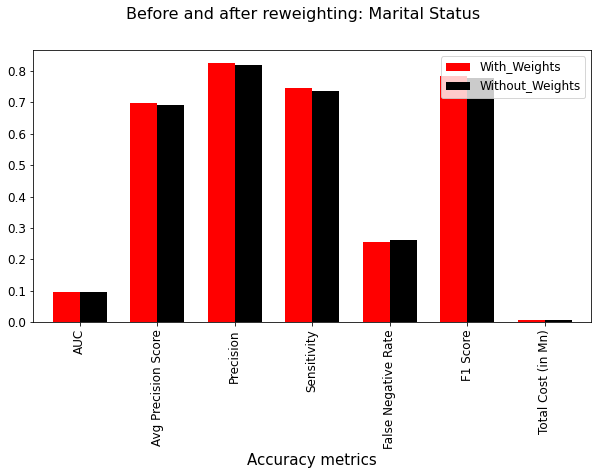

In [ ]:
txt='Marital Status'

ax = model_table_df.iloc[[0,2,3,4,5,6,8],:].plot.bar(x='Metrics', rot=90, width = 0.7, 
                                                       color=['red', 'black'], figsize=(10,5), fontsize=12)
plt.suptitle('Before and after reweighting: {}'.format(txt),  fontsize=16, y=1)



patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Accuracy metrics', fontsize=15)
plt.show()

# Fairness metrics

In [ ]:
X_train_dp_reweighted, X_test_dp_reweighted, y_train_dp_reweighted, y_test_dp_reweighted = train_test_split(df.drop('Target', axis = 1), df['Target'], test_size = 0.30, random_state = 42)
X_train, X_test, y_train, y_test = train_test_split(df.drop('Target', axis = 1), df['Target'], test_size=0.30, random_state=6666)

X_train1 = X_train_raw_reweighted.drop(columns=["Marital_status_weight",'Gender','Nacionality'],axis=1)
X_test1 = X_test_raw_reweighted.drop(columns=["Marital_status_weight",'Nacionality','Gender'],axis = 1)

X_train_weights = X_train_dp_reweighted['Marital_status_weight']
X_test_weights = X_test_dp_reweighted['Marital_status_weight']

X_train1 = X_train_dp_reweighted.drop(columns=["Marital_status_weight",'Gender','Nacionality'],axis=1)
X_test1 = X_test_dp_reweighted.drop(columns=["Marital_status_weight",'Gender','Nacionality'],axis=1)

clf_wow = LogisticRegression(random_state=0, solver='lbfgs',
                              multi_class='ovr').fit(X_train1, y_train_dp_reweighted)

y_test = y_test_dp_reweighted
y_train = y_train_dp_reweighted

column = 'Marital_status'
y_pred_wow = clf_wow.predict(X_test1)
y_pred_prob_wow = clf_wow.predict_proba(X_test1)[:,0]

print("Accuracy of the model without weights:", clf_wow.score(X_test1, y_test_dp_reweighted))

A_wow=clf_wow.score(X_test1[X_test1[column]==0], y_test_dp_reweighted[X_test1[column]==0]) #pval = 0 is Priviliged
B_wow=clf_wow.score(X_test1[X_test1[column]==1], y_test_dp_reweighted[X_test1[column]==1]) #pval = 1 is Unpriviliged
print("Accuracy difference between two groups:", abs(B_wow-A_wow)*100, "%")




clf_ww = LogisticRegression(random_state=0, solver='lbfgs',
                              multi_class='ovr').fit(X_train1, y_train_dp_reweighted, sample_weight=X_train_weights)

y_pred_ww = clf_ww.predict(X_test1)
y_pred_prob_ww = clf_ww.predict_proba(X_test1)[:,0]

print("Accuracy of the model with weights:", clf_ww.score(X_test1, y_test_dp_reweighted))

A_ww=clf_ww.score(X_test1[X_test1[column]==0], y_test_dp_reweighted[X_test1[column]==0])
B_ww=clf_ww.score(X_test1[X_test1[column]==1], y_test_dp_reweighted[X_test1[column]==1])
print("Accuracy difference between two groups:", abs(B_ww-A_ww)*100, "%" )




Accuracy of the model without weights: 0.865210843373494
Accuracy difference between two groups: 2.830868519900265 %
Accuracy of the model with weights: 0.8629518072289156
Accuracy difference between two groups: 3.4271429209155158 %


               Metrics  With_Weights  Without_Weights
0                  AUC      0.021054         0.017111
1        Avg Precision      0.100823         0.101571
2              Eq Oppo      0.045801         0.079134
3           Eq Of Odds      0.577428         0.556769
4            Precision      0.015239         0.001600
5          Demo Parity      0.142602         0.167174
6        Avg Odds Diff      0.049516         0.074450
7        Pred Equality      0.053231         0.069767
8   Treatment Equality      0.222222         0.624138
9          Pred Parity      0.015239         0.001600
10           Cost Diff -61800.000000    -60300.000000
11          Total Cost  82200.000000     80900.000000
12  Total Cost (in Mn)      0.008220         0.008090


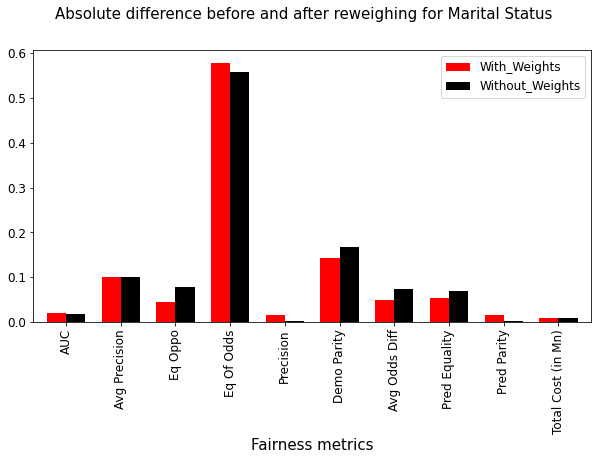

In [ ]:
choice = 'Marital_status'
pval = 0
upval = 1

ww=[perf_metrics(y_test, y_pred_prob_ww, y_pred_ww, X_test1, choice, pval, upval)]
wow=[perf_metrics(y_test, y_pred_prob_wow, y_pred_wow, X_test1, choice, pval, upval)]
headers=["AUC", "Avg Precision", "Eq Oppo", "Eq Of Odds", "Precision", 
         "Demo Parity", "Avg Odds Diff", "Pred Equality", "Treatment Equality", "Pred Parity",
         "Cost Diff", "Total Cost"]


ww_wow={'Metrics':headers, 
             'With_Weights':list(ww[0]), 'Without_Weights':list(wow[0])}

compare_table=pd.DataFrame.from_dict(ww_wow)
compare_table.loc[12] = ['Total Cost (in Mn)', compare_table.iloc[11,1]/10000000, compare_table.iloc[11,2]/10000000]


print(compare_table)

ax = compare_table.iloc[[0,1,2,3,4,5,6,7,9,12],:].plot.bar(x='Metrics', rot=90, width = 0.7, color=['red', 'black'], 
                                                           figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference before and after reweighing for {}'.format(txt),  
             fontsize=15, y=1)
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)
ax.set_xlabel('Fairness metrics', fontsize=15)
plt.show()

<a id="6"> </a> 

<div class="alert alert-block alert-warning">
<span style="font-family:Futura Next; font-size:2em;">Accuracy-cost-fairness trade-off</span>
</div>

In [ ]:
thresholds = np.arange(0, 1.01, 0.01)

In [ ]:
EOpp, EOdds, demo_parity, AOD, p_eq, TE, pp, TNR, precision, FPR, f1, roc, sensitivity, fnr, fp, fn, cost = on_same_threshold(X_test1, y_test, choice, y_pred_prob_wow, pval, upval)

In [ ]:
cost = [x / 100000 for x in cost]

same_thresholds={'Threshold':thresholds, 
             'Eq of Opportunity':EOpp, 'Eq of Odds':EOdds, 'Demographic Parity': demo_parity,
                 'Avg Odds':AOD, 'Pred equality':p_eq, 'Treatment eq':TE, 'Pred Parity':pp,
                 'True Negative Rate': TNR, 'Precision': precision, 'False Positive Rate':FPR, 
                 "F1": f1, "Area Under Curve":roc , "Sensitivity":sensitivity, "False Negative Rate":fnr,
                 "FP":fp, "FN":fn,
                 'Cost':cost}

same_thresholds_table=pd.DataFrame.from_dict(same_thresholds)
same_thresholds_table = same_thresholds_table.fillna(0)
#same_thresholds_table.tail(10)

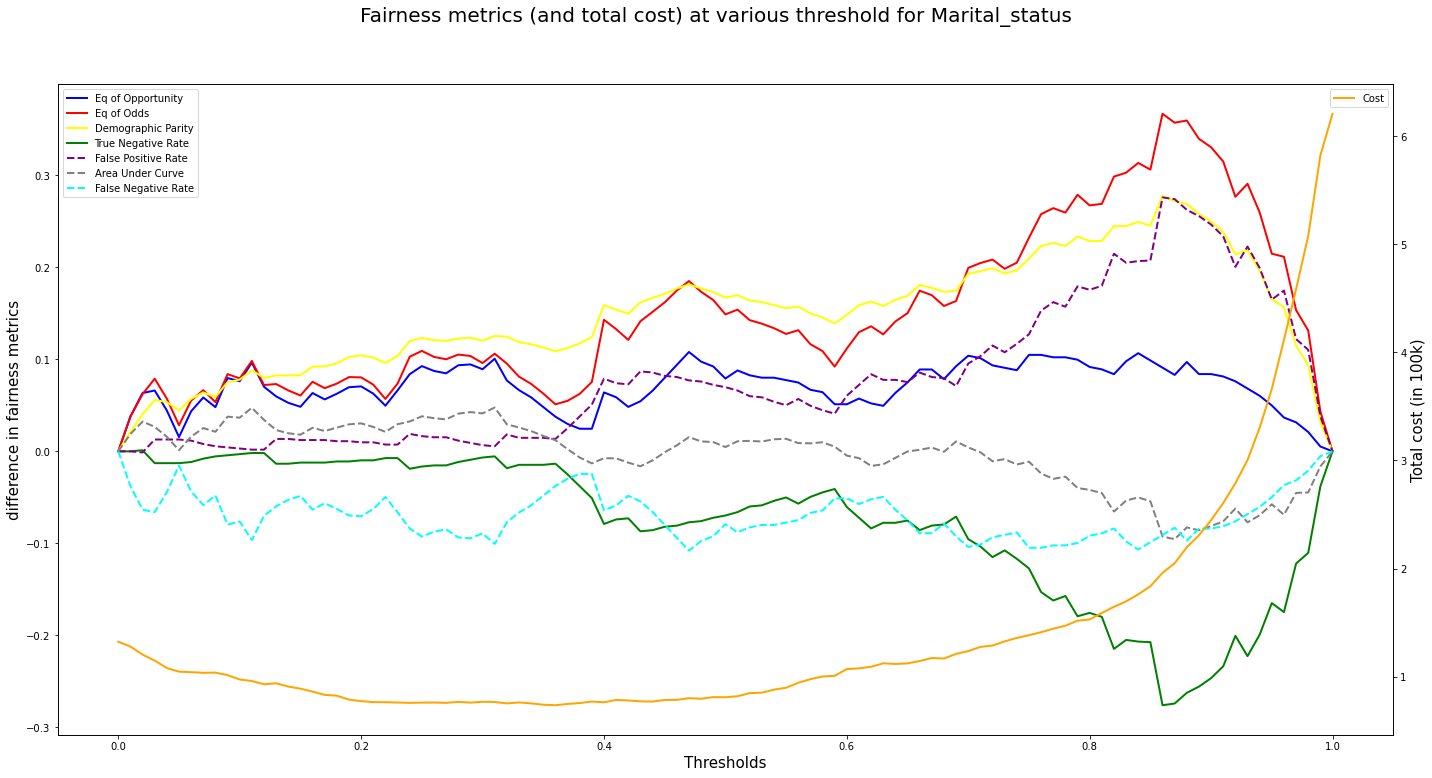

In [ ]:
fig, ax1 = plt.subplots(figsize=(20,10))

fig.suptitle('Fairness metrics (and total cost) at various threshold for {}'.format(choice), fontsize=20, y=1.05)


ax1.plot( 'Threshold', 'Eq of Opportunity', data=same_thresholds_table, marker='', color='blue', linewidth=2)
ax1.plot( 'Threshold', 'Eq of Odds', data=same_thresholds_table, marker='', color='red', linewidth=2)
ax1.plot( 'Threshold', 'Demographic Parity', data=same_thresholds_table, marker='', color='yellow', linewidth=2)
ax1.plot( 'Threshold', 'True Negative Rate', data=same_thresholds_table, marker='', color='green', linewidth=2)
ax1.plot( 'Threshold', 'False Positive Rate', data=same_thresholds_table, marker='', linestyle='--', color='purple', linewidth=2)
ax1.plot( 'Threshold', 'Area Under Curve', data=same_thresholds_table, marker='', linestyle='--', color='grey', linewidth=2)
ax1.plot( 'Threshold', 'False Negative Rate', data=same_thresholds_table, marker='', linestyle='--', color='cyan', linewidth=2)

ax2 = ax1.twinx() 
ax2.plot( 'Threshold', 'Cost', data=same_thresholds_table, marker='', color='orange', linewidth=2)



patches, labels = ax1.get_legend_handles_labels()
ax1.legend(patches, labels, loc='upper left', fontsize=10)

patches, labels = ax2.get_legend_handles_labels()
ax2.legend(patches, labels, loc='upper left', fontsize=14)

ax1.set_ylabel('difference in fairness metrics', fontsize=15)
ax2.set_ylabel('Total cost (in 100k)', fontsize=15)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.legend()
ax1.set_xlabel('Thresholds', fontsize=15)
plt.show()

# ACF

In [ ]:
final_df = pd.read_csv('dataset_featured_v2.csv')

In [ ]:
X = final_df.drop('Target', axis=1)
Y = final_df.Target

In [ ]:
PII_columns = ['Marital_status','Gender','Nacionality']

In [ ]:
model = ACF(X, Y, PII_columns)

In [ ]:
model.fit()

In [ ]:
choice = "Marital_status"

acf_metrics, logistic_reg_fair_metrics = model.score(choice, 0, 1)

In [ ]:
labels, log_reg_model = zip(*logistic_reg_fair_metrics)
headers, acf_model = zip(*acf_metrics)
ACF_dict={'Metrics':headers[0:6], 
             'Baseline Model':list(log_reg_model[2:8]), 'ACF Fair Model':list(acf_model[0:6])}
ACF_table=pd.DataFrame.from_dict(ACF_dict)
ACF_table

,Metrics,Baseline Model,ACF Fair Model
0,Equal Opps,0.043176,0.002493
1,PredEq,0.054457,0.043444
2,Equal Odds,0.097632,0.040951
3,PredParity,0.012306,0.001042
4,DemoParity,0.142602,0.068607
5,AOD,0.048816,0.020476


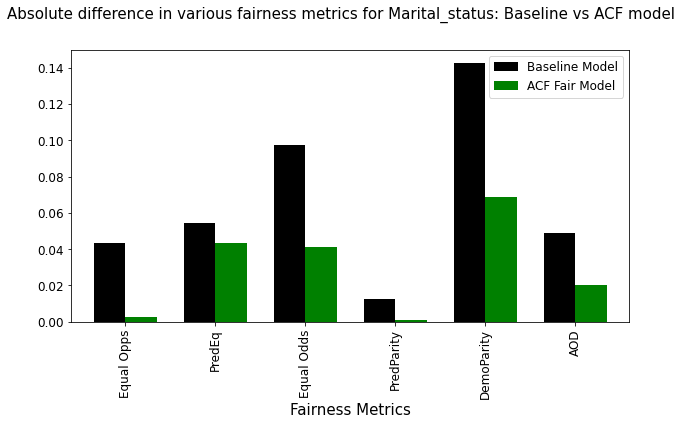

In [ ]:
ax = ACF_table.plot.bar(x='Metrics', rot=90, width = 0.7, color=['black', 'green'], figsize=(10,5), fontsize=12)
plt.suptitle('Absolute difference in various fairness metrics for {}: Baseline vs ACF model'.format(choice),  
             fontsize=15, y=1)

patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, loc='upper right', fontsize=12)

ax.set_xlabel('Fairness Metrics', fontsize=15)
plt.show()

# Explainable AI using Shap

In [ ]:
model = None
with open('picklefiles/without_reweight/raw_sklearn_lr.pkl', 'rb') as pfile:
    model = pickle.load(pfile)

In [ ]:
X = df_raw.drop([*columns_to_drop, 'Marital_status_weight'], axis=1)
Y = df_raw.Target

X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42, test_size=0.3)

In [203]:
x_train_scaled = scaler.fit_transform(X_train)
x_test_scaled = scaler.fit_transform(X_test)

In [227]:
shap_explainer = shap.LinearExplainer(model, x_train_scaled, feature_perturbation="interventional")
shap_values = shap_explainer.shap_values(x_test_scaled)
shap.force_plot(shap_explainer.expected_value, shap_values[1, :], )

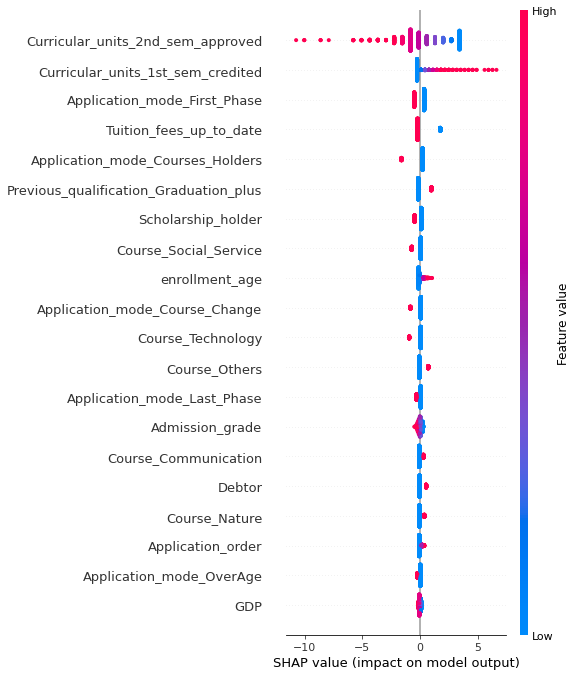

In [231]:
shap.summary_plot(shap_values, x_test_scaled, feature_names=X_train.columns)